In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [117]:
import util.normalization as norm
import util.model as models
import util.utility as util

In [146]:
df = pd.read_csv('./sample-mcd.csv', encoding='latin1')
df = df[['reviewer_id', 'review_time', 'review', 'rating']]

df['rating'] = df['rating'].apply(lambda x: int(x.split(" ")[0]))

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   reviewer_id  100 non-null    int64 
 1   review_time  100 non-null    object
 2   review       100 non-null    object
 3   rating       100 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 3.3+ KB
None


,reviewer_id,review_time,review,rating
0,1,3 months ago,Why does it look like someone spit on my food?...,1
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4
2,3,5 days ago,Made a mobile order got to the speaker and che...,1
3,4,a month ago,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,5
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1


# Normalization

In [119]:
df_sm = df[['reviewer_id', 'review']].copy()

# Remove non-ASCII
df_sm['review_clean'] = df_sm['review'].apply(norm.remove_non_ascii)

# Expand contractions
df_sm['review_clean'] = df_sm['review_clean'].apply(norm.expand_contractions)

# Remove characters
df_sm['review_clean'] = df_sm['review_clean'].apply(norm.remove_characters, args=(True, ))

In [120]:
df_sm.head()

,reviewer_id,review,review_clean
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...
1,2,It'd McDonalds. It is what it is as far as the...,It would McDonalds. It is what it is as far as...
2,3,Made a mobile order got to the speaker and che...,Made a mobile order got to the speaker and che...
3,4,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,My mc. Crispy chicken sandwich was customer s...
4,5,"I repeat my order 3 times in the drive thru, a...","I repeat my order 3 times in the drive thru, a..."


In [121]:
from transformers import pipeline

classifier = pipeline("summarization")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [122]:
def get_summarize(text, min_length=25, max_length=68):
    result = classifier(text, min_length=min_length, max_length=max_length)
    return result[0]['summary_text']

In [123]:
tqdm.pandas()
df_sm['summarize'] = df_sm['review_clean'].progress_apply(get_summarize)
print(df_sm.info())
df_sm.head()

 47%|██████████████████████████████████████                                           | 47/100 [02:12<02:06,  2.38s/it]Your max_length is set to 68, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:54<00:00,  2.95s/it]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   reviewer_id   100 non-null    int64 
 1   review        100 non-null    object
 2   review_clean  100 non-null    object
 3   summarize     100 non-null    object
dtypes: int64(1), object(3)
memory usage: 3.3+ KB
None


,reviewer_id,review,review_clean,summarize
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...
1,2,It'd McDonalds. It is what it is as far as the...,It would McDonalds. It is what it is as far as...,The staff at McDonalds are always friendly an...
2,3,Made a mobile order got to the speaker and che...,Made a mobile order got to the speaker and che...,Never got the refund in the app. Made a mobil...
3,4,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,My mc. Crispy chicken sandwich was customer s...,My mc. Crispy chicken sandwich was customer ...
4,5,"I repeat my order 3 times in the drive thru, a...","I repeat my order 3 times in the drive thru, a...","I repeat my order 3 times in the drive thru, ..."


In [124]:
df_sm['summarize'].iloc[2]

' Never got the refund in the app. Made a mobile order got to the speaker and checked it in. Line was not moving so I had to leave otherwise Id be late for work . Never got refund in app. Called them and they said I could only get my money back in person because it was stuck in the system .'

In [125]:
df_sm['review_clean'].iloc[2]

'Made a mobile order got to the speaker and checked it in.\nLine was not moving so I had to leave otherwise Id be late for work.\nNever got the refund in the app.\nI called them and they said I could only get my money back in person because it was stuck in the system.\nWent there in person the next day  and the manager told me she wasn'

In [126]:
# Sentence Tokenization
df_st = df_sm.copy()
df_st['token_sentence'] = df_st['summarize'].apply(norm.sentence_tokenize)
df_st = df_st.explode('token_sentence')
df_st['token_sentence'] = df_st['token_sentence'].str.strip()

# Remove characters
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.remove_characters, args=(True, ))

# Lemmatization
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.lemmatize_text)

# Get Aspect (Rules Based)

In [127]:
# Get aspect from rules
tqdm.pandas()
df_st['sub_aspect'] = df_st['token_sentence']\
                        .progress_apply(util.get_aspect_rules)

print(df_st.info())
df_st.head()

100%|████████████████████████████████████████████████████████████████████████████████| 385/385 [00:13<00:00, 28.62it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 385 entries, 0 to 99
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewer_id     385 non-null    int64 
 1   review          385 non-null    object
 2   review_clean    385 non-null    object
 3   summarize       385 non-null    object
 4   token_sentence  385 non-null    object
 5   sub_aspect      385 non-null    object
dtypes: int64(1), object(5)
memory usage: 21.1+ KB
None


,reviewer_id,review,review_clean,summarize,token_sentence,sub_aspect
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...,why do it look like someone spit on my food,{someone spit}
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...,i have a normal transaction,{normal transaction}
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...,everyone be chill and polite,{everyone}
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...,but now i dont want to eat this .,{}
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...,im try not to think about what this milky whit...,{clear substance}


In [128]:
mask = df_st['sub_aspect'].apply(lambda x: False if len(x) == 0 else True).values

df_prc = df_st.groupby(['reviewer_id'])\
                .agg({'sub_aspect': lambda x: set().union(*x),})\
                .reset_index()

df_prc = df_sm.merge(df_prc, on='reviewer_id', how='left')
print(df_prc.info())
df_prc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   reviewer_id   100 non-null    int64 
 1   review        100 non-null    object
 2   review_clean  100 non-null    object
 3   summarize     100 non-null    object
 4   sub_aspect    100 non-null    object
dtypes: int64(1), object(4)
memory usage: 4.0+ KB
None


,reviewer_id,review,review_clean,summarize,sub_aspect
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...,"{normal transaction, clear substance, everyone..."
1,2,It'd McDonalds. It is what it is as far as the...,It would McDonalds. It is what it is as far as...,The staff at McDonalds are always friendly an...,"{mcdonalds, food, atmosphere, staff}"
2,3,Made a mobile order got to the speaker and che...,Made a mobile order got to the speaker and che...,Never got the refund in the app. Made a mobil...,"{refund, money, line, mobile order}"
3,4,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,My mc. Crispy chicken sandwich was customer s...,My mc. Crispy chicken sandwich was customer ...,"{chicken sandwich, customer, crispy chicken, c..."
4,5,"I repeat my order 3 times in the drive thru, a...","I repeat my order 3 times in the drive thru, a...","I repeat my order 3 times in the drive thru, ...","{double filet, close attention, order, large m..."


In [129]:
df_prc['sub_aspect'].iloc[0]

{'clear substance', 'everyone', 'normal transaction', 'someone spit'}

In [130]:
df_prc['summarize'].iloc[0]

' Why does it look like someone spit on my food? I had a normal transaction,  everyone was chill and polite, but now i dont want to eat this . Im trying not to think about what this milky white/clear substance is all over my food, i d sure am not coming back .'

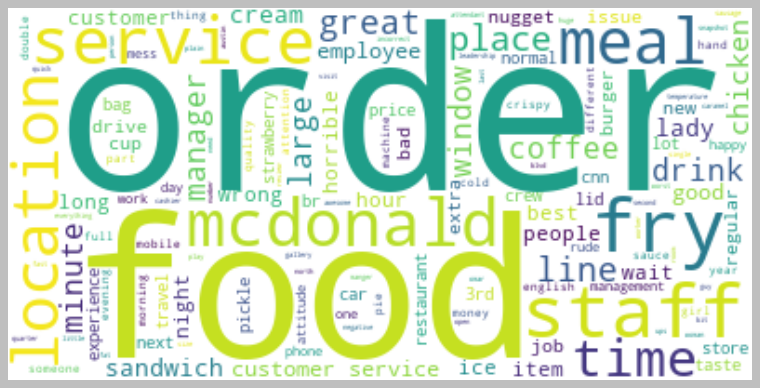

In [131]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
sub_aspect = df_prc['sub_aspect'].values
for i in range(df_prc.shape[0]):
    text = text + " " + " ".join(list(sub_aspect[i]))
    

text = text.strip()

wordcloud = WordCloud(background_color='white').generate(text)
plt.style.use('classic')
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Get Topic

In [132]:
def get_optimum_lda(dictionary, corpus, texts, limit,
                    start=2, step=1, get_result=False,
                    iterations=20, passes=1):
    coherence_values = []
    
    for n in range(start, limit, step):
        lda = gensim.models.LdaMulticore(corpus=corpus,
                                         num_topics=n,
                                         id2word=dictionary,
                                         iterations=iterations,
                                         passes=passes)
        
        # Create coherence
        coherence_model = CoherenceModel(model=lda, 
                                         texts=texts,
                                         dictionary=dictionary, 
                                         coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    
    
    opt_num_topics = start + coherence_values.index(max(coherence_values))
    
    lda_opt = gensim.models.LdaMulticore(corpus=corpus,
                                         num_topics=opt_num_topics,
                                         id2word=dictionary)
    
    if get_result:
        print(coherence_values)
    
    return lda_opt



In [133]:
import gensim
from gensim.models import CoherenceModel


texts = df_prc['summarize'].apply(util.preprocess_lda)
# texts = df_prc['sub_aspect'].apply(lambda x: ', '.join(list(x))).apply(util.preprocess_lda)

dictionary = gensim.corpora.Dictionary(texts)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100_000)
bow_corpus = [dictionary.doc2bow(doc) for doc in texts]

lda_opt = get_optimum_lda(dictionary, bow_corpus,
                          texts, 10, get_result=True,
                          passes=75, iterations=150)

[0.34116640883448235, 0.3411664088344824, 0.34116640883448235, 0.3411664088344824, 0.3411664088344824, 0.34116640883448246, 0.34116640883448246, 0.3411664088344824]


In [134]:
# Print topic
for idx, topic in lda_opt.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.455*"service" + 0.176*"order" + 0.176*"drive" + 0.064*"food" + 0.064*"time" + 0.064*"mcdonalds"
Topic: 1 
Words: 0.308*"food" + 0.187*"order" + 0.187*"drive" + 0.157*"service" + 0.096*"mcdonalds" + 0.065*"time"
Topic: 2 
Words: 0.657*"mcdonalds" + 0.155*"order" + 0.083*"drive" + 0.083*"service" + 0.011*"food" + 0.011*"time"
Topic: 3 
Words: 0.756*"order" + 0.054*"drive" + 0.054*"food" + 0.054*"service" + 0.054*"time" + 0.029*"mcdonalds"
Topic: 4 
Words: 0.431*"drive" + 0.273*"service" + 0.114*"order" + 0.114*"time" + 0.061*"food" + 0.008*"mcdonalds"
Topic: 5 
Words: 0.705*"food" + 0.137*"mcdonalds" + 0.050*"order" + 0.050*"drive" + 0.050*"service" + 0.006*"time"
Topic: 6 
Words: 0.393*"time" + 0.329*"order" + 0.167*"drive" + 0.037*"food" + 0.037*"mcdonalds" + 0.037*"service"


In [135]:
def predict_topic(text):
    text = util.preprocess_lda(text)
    bow_vector = dictionary.doc2bow(text)
    
    result = sorted(lda_opt[bow_vector], 
                    key=lambda x: -1*x[1])[0][0]
    
    return result
    
# Extract keywords into a dictionary or list
threshold = 0.05
topics_dict = {}
for topic_num, topic in lda_opt.show_topics(num_topics=10,
                                                num_words=10,
                                                formatted=False):
    keywords = [word for word, w in topic if w > threshold]
    topics_dict[topic_num] = keywords

In [136]:
topics_dict

{0: ['service', 'order', 'drive', 'food', 'time', 'mcdonalds'],
 1: ['food', 'order', 'drive', 'service', 'mcdonalds', 'time'],
 2: ['mcdonalds', 'order', 'drive', 'service'],
 3: ['order', 'drive', 'food', 'service', 'time'],
 4: ['drive', 'service', 'order', 'time', 'food'],
 5: ['food', 'mcdonalds', 'order', 'drive', 'service'],
 6: ['time', 'order', 'drive']}

In [137]:
tqdm.pandas()
df_prc['topic'] = df_prc['summarize'].progress_apply(predict_topic)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 423.06it/s]


In [138]:
tqdm.pandas()
df_prc['topic_keys'] = df_prc['topic'].progress_apply(lambda x: topics_dict[x])

100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<?, ?it/s]


In [139]:
df_prc

,reviewer_id,review,review_clean,summarize,sub_aspect,topic,topic_keys
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,Why does it look like someone spit on my food...,"{normal transaction, clear substance, everyone...",5,"[food, mcdonalds, order, drive, service]"
1,2,It'd McDonalds. It is what it is as far as the...,It would McDonalds. It is what it is as far as...,The staff at McDonalds are always friendly an...,"{mcdonalds, food, atmosphere, staff}",5,"[food, mcdonalds, order, drive, service]"
2,3,Made a mobile order got to the speaker and che...,Made a mobile order got to the speaker and che...,Never got the refund in the app. Made a mobil...,"{refund, money, line, mobile order}",3,"[order, drive, food, service, time]"
3,4,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,My mc. Crispy chicken sandwich was customer s...,My mc. Crispy chicken sandwich was customer ...,"{chicken sandwich, customer, crispy chicken, c...",0,"[service, order, drive, food, time, mcdonalds]"
4,5,"I repeat my order 3 times in the drive thru, a...","I repeat my order 3 times in the drive thru, a...","I repeat my order 3 times in the drive thru, ...","{double filet, close attention, order, large m...",6,"[time, order, drive]"
...,...,...,...,...,...,...,...
95,96,If I could give negative stars I would. This l...,If I could give negative stars I would. This l...,The staff is horrible. Corporate needs to sen...,"{corporate need, basic manor, staff, work ethi...",6,"[time, order, drive]"
96,97,When ordering food the employees conveniently ...,When ordering food the employees conveniently ...,When ordering food the employees forgot to tu...,"{order food, microphone, employee, mess}",5,"[food, mcdonalds, order, drive, service]"
97,98,I donÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯Ã...,I dont usually review places but this location...,I dont usually review places but this locatio...,"{location, place, rude service, order wrong}",0,"[service, order, drive, food, time, mcdonalds]"
98,99,Allways has the best Fries and Ice cream in th...,Allways has the best Fries and Ice cream in th...,Allways has the best Fries and Ice cream in t...,"{allways, best fry, ice cream}",0,"[service, order, drive, food, time, mcdonalds]"


# Save Result

In [147]:
result = df_prc.copy()
result = result.merge(df[['reviewer_id','rating']],
                      on='reviewer_id',
                      how='left')

result['sub_aspect'] = result['sub_aspect'].apply(lambda x: ', '.join(list(x)))
# result['sub_aspect'] = result['sub_aspect'].apply(lambda x: list(x))
result['topic_keys'] = result['topic_keys'].apply(lambda x: ', '.join(x))

result.to_csv("coding_mcd.csv", index=False)